# Model: Logistic Regression

## Imports and Settings

In [5]:
# Helper libraries
import warnings
from itertools import combinations

# Scientific libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split

# Local Imports
from churn_detection.utils import get_feature_names
from churn_detection.data import load_data
from churn_detection.visualization import plot_confusion_table
from churn_detection.preprocessing import preprocess_data, split_data
from churn_detection.features import (InteractionStrengthExtractor,
                                      FeatureConcatenator, 
                                      RareCategoryEncoder)
from churn_detection.models.ml_pipeline import MLPipeline, create_pipeline
from churn_detection.paths import PARENT_DIR
from churn_detection.config import load_config


%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Various settings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=4)
sns.set_theme()
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading and Preparing Data

In [2]:
churn = load_data()

In [7]:
preprocessed_data = preprocess_data(churn)
numeric_variables, categorical_variables = get_feature_names(preprocessed_data)

In [8]:
extractor = InteractionStrengthExtractor("partner", "paymentmethod", ordinal_encode=True)
extractor.fit(preprocessed_data)

new_preprocessed_data = extractor.transform(preprocessed_data)
strength_feature = extractor.get_strength_col_name()

discrete_vars_pairs = list(combinations(categorical_variables, 2))
concat_transformer = FeatureConcatenator(feature_pairs=discrete_vars_pairs)
concat_preprocessed_data = concat_transformer.transform(new_preprocessed_data)

In [10]:
prep_train, prep_test = train_test_split(
        concat_preprocessed_data, 
        test_size=0.2, 
        random_state=1
)

X_train, y_train = split_data(prep_train)
X_test, y_test = split_data(prep_test)

In [11]:
continuous_set = numeric_variables + [strength_feature]
discrete_set = categorical_variables + concat_transformer.get_new_feature_names()

## Model Training and Evaluation

In [12]:
config_dir = PARENT_DIR / "configs"
config = load_config(config_dir / "config.yaml")

In [15]:
config["feature_engineering"]["params"]["numerical"]["variables"] = continuous_set
config["feature_engineering"]["params"]["numerical"]["steps"] = [("scaler", RobustScaler())]

config["feature_engineering"]["params"]["categorical"]["variables"] = discrete_set
config["feature_engineering"]["params"]["categorical"]["steps"] = [
        ("rarecat", RareCategoryEncoder(tol=0.2)),
        ("catencoder", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"))
]

In [17]:
lr_pipeline = create_pipeline(config)

In [18]:
lr_pipeline.train(X_train, y_train)

In [20]:
results = lr_pipeline.evaluate(X_test, y_test)
print(f"Results: {results}")

Results: {'f1': np.float64(0.6013793103448276), 'recall': np.float64(0.6264367816091954)}


## Model Tuning and Tracking

In [21]:
from churn_detection.models.experiment import ExperimentManager

In [22]:
expr_pipeline = create_pipeline(config)
expr_manager = ExperimentManager(expr_pipeline, experiment_name="churn_logistic_regression")

### Grid Search with Few Parameters

In [23]:
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [100, 200, 300]
}
grid_results = expr_manager.grid_search(
    X_train, 
    y_train, 
    param_grid, 
    scoring='recall',
    n_jobs=1
)
grid_results["best_params"]

{'C': 10, 'max_iter': 200}

### Grid Search with More Parameters

In [25]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] ,
    'max_iter': [100, 200, 300],
    'solver': ["saga", "liblinear"],
    'penalty': ["l1", "l2"]
}
grid_results = expr_manager.grid_search(
    X_train, 
    y_train, 
    param_grid, 
    scoring='recall',
    n_jobs=1
)
grid_results["best_params"]

{'C': 1000, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [31]:
best_experiment = expr_manager.get_best_experiment()
best_experiment["experiment_id"]

'churn_logistic_regression_20241222_214048'

## Best Model on Test Data

In [32]:
expr_manager.apply_best_params(best_experiment["experiment_id"])

In [33]:
expr_manager.base_pipeline.train(X_train, y_train)

### Final Scores

In [37]:
results = expr_manager.base_pipeline.evaluate(X_test, y_test)
print(f"Results: {results}")

Results: {'f1': np.float64(0.6029609690444145), 'recall': np.float64(0.6436781609195402)}


### Confusion Table on Test Set

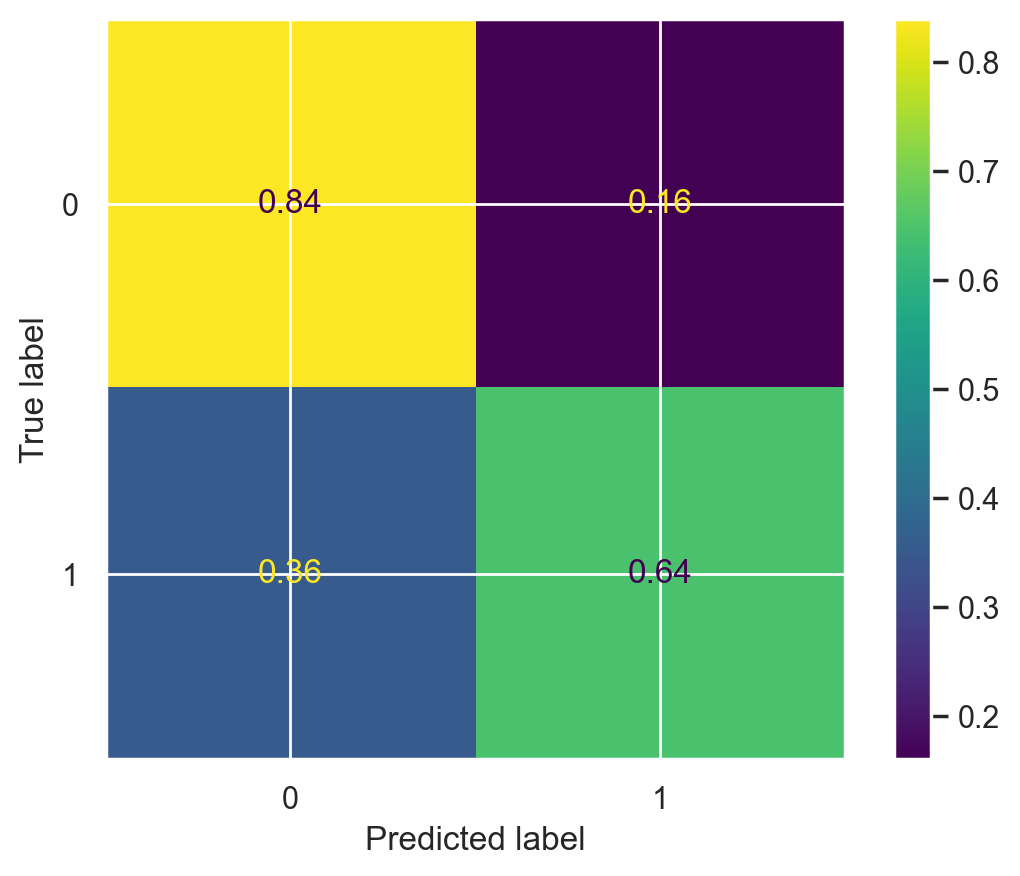

In [38]:
test_predictions = expr_manager.base_pipeline.predict(X_test)
plot_confusion_table(y_test, test_predictions)

This classifier's skill is better in peformance than previous ones for reaching churned customers.